In [2]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint as sp_randint
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)

In [3]:
dfs = {}
for file in ['../data/MovAve15_Data.csv', '../data/MovAve30_Data.csv',
             '../data/MovAve60_Data.csv', '../data/MovAve90_Data.csv']:
    dfs[file[14:16]] = pd.read_csv(file)

In [4]:
class CustomKFold:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split(self, df, y, groups=None):
        from sklearn.model_selection import StratifiedKFold
        import numpy as np

        sk = StratifiedKFold(random_state=0, n_splits=self.n_splits, shuffle=True)

        train_all = df[df['year'] < 2019]

        for train_idx, valid_idx in sk.split(np.zeros(train_all.shape[0]), train_all['year']):
            yield (train_idx, valid_idx)

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

best estimator accuracy for 15: 0.4934
best estimator accuracy for 30: 0.4959
best estimator accuracy for 60: 0.5036
best estimator accuracy for 90: 0.5154


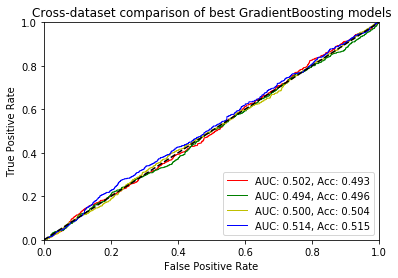

In [6]:
colors = {'15': 'r',
          '30': 'g',
          '60': 'y',
          '90': 'b',
          }

for name, df in dfs.items():

    train = df[df['year'] < 2019]
    test = df[df['year'] == 2019]

    x_train = train.drop(['Target_Var'], axis=1)
    y_train = train['Target_Var']

    x_test = test.drop(['Target_Var'], axis=1)
    y_test = test['Target_Var']
    
    with open('../results/best_gb_model_{}.pckl'.format(name), 'rb') as f:
        gb = pickle.load(f)
    with open('../results/best_gb_model_cv_{}.pckl'.format(name), 'rb') as f:
        gb_cv = pickle.load(f)
    with open('../results/cols_{}.pckl'.format(name), 'rb') as f:
        cols = pickle.load(f)
    
    accuracy = gb.score(x_test[cols], y_test)
    print('best estimator accuracy for {}: {:.4f}'.format(name, accuracy))
    fpr, tpr, thresholds = roc_curve(y_test, gb.predict_proba(x_test[cols])[:,1])
    best_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, colors[name], lw=1, label='AUC: {:.3f}, Acc: {:.3f}'.format(best_auc, accuracy))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-dataset comparison of best GradientBoosting models')

plt.xlim((0,1))
plt.ylim((0,1))
plt.savefig('gb-comparison-datasets.png')
